In [1]:
#import sys
#sys.path.append('/Users/cauaveiga/Documents/ENGENHARIA FÍSICA/3º ANO/2º Semestre/Métodos Computacionais')
#import pde as pde

import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.linalg

import timeit


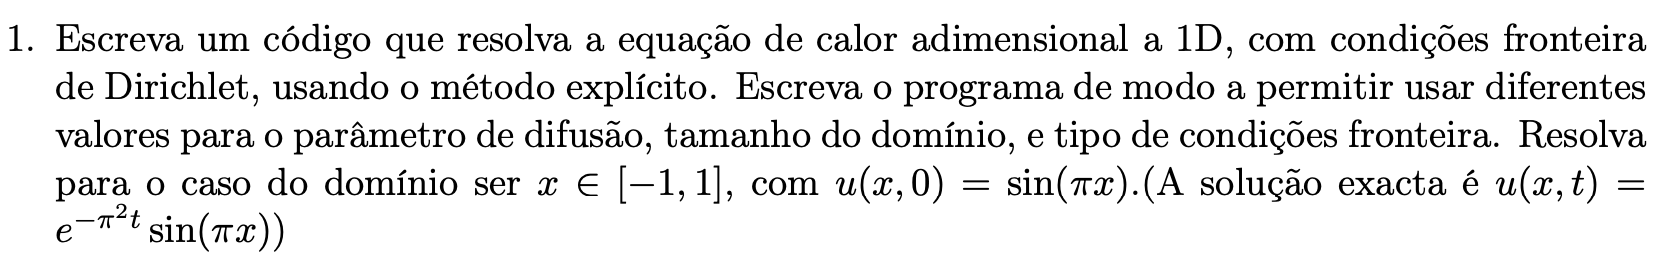

In [2]:
def Forward_Euler(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''

    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    print('dx = {:.5}'.format(dx))

    
    
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    print(f'número de Fourier = {round(F,6)}')
    u    = np.zeros(Nx+1)           # incógnita u no novo nível de tempo
    u_1  = np.zeros(Nx+1)           # incógnita u no nível de tempo anterior

    # Aplicar condição inicial  u(x,0) = I(x)
    
    u_1 = cond_inicial(x,xf,a,F)
    init = u_1.copy()
        
    t = 0
    while t < Tf+dt:  
        
        # Calcular u em todos os nodos internos
        u[1:Nx] = u_1[1:Nx] + F*(u_1[0:Nx-1] - 2*u_1[1:Nx] + u_1[2:Nx+1])
            
        # Aplicar condições fronteira (aqui nem seria necessário! Porquê?)
        u[0], u[Nx] = cond_fronteira(xi,xf,t)

        # Actualizar u_1 antes de passar ao próximo passo
        u,u_1 = u_1,u
        
        t += dt
    
    return x,u,init

In [3]:
# Funções para o exemplo

def initial(*args):
    x = args[0]
    return np.sin(np.pi*x)

def front(*args):
    return 0,0

def exat(x,t=0.02):
    return np.exp(-np.pi**2 * t)*np.sin(np.pi*x)

dx = 0.03125
número de Fourier = 0.5


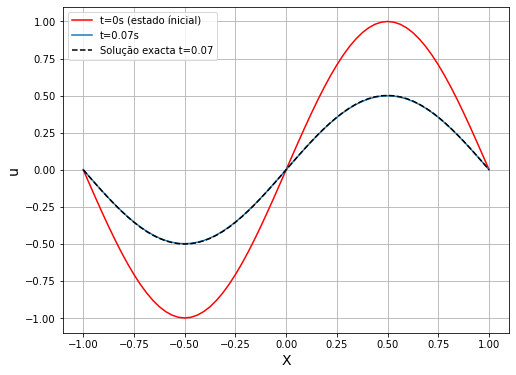

In [4]:
T = 0.07

x,u,init = Forward_Euler(a=1, Nx=64, xi=-1, xf=1,Tf=T, cond_inicial=initial, cond_fronteira=front)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label=f't={T}s')
plt.plot(x,exat(x,T),'--',color='black',label=f'Solução exacta t={T}')

plt.xlabel('X',fontsize=14)
plt.ylabel('u',fontsize=14)

plt.legend()
plt.grid()
plt.show()

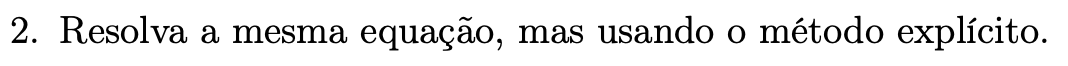

In [5]:
def Backward_Euler(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''
    # Calculo parametros
    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    u   = np.zeros(Nx+1)          # incógnita u no novo nível de tempo
    u_1 = np.zeros(Nx+1)          # incógnita u no nível de tempo anterior
    
    # Representação de uma matriz esparsa e do vector do lado direito
    principal  = np.zeros(Nx+1)
    inferior = np.zeros(Nx)
    superior = np.zeros(Nx)
    b     = np.zeros(Nx+1)

    # Precálculo da matriz esparsa
    principal[:] = 1 + 2*F
    inferior[:] = -F  
    superior[:] = -F 
    
    # Inserir condições fronteira na matriz
    principal[0] = 1
    principal[Nx] = 1

    A = scipy.sparse.diags(
        diagonals=[principal, inferior, superior],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    #print (A.todense())  # Transforma na forma densa da matriz, para verificação.

    # Inserir condição inicial
    u_1 = cond_inicial(x,xf,a,F)
    init = u_1.copy()

    t = 0
    while t < Tf+dt: 
        
        b = u_1 # Vector b (da direita) = u_{t-1}
        b[0], b[-1] = cond_fronteira(xi,xf,t)  # condições fronteira
        u[:] = scipy.sparse.linalg.spsolve(A, b) # Resolvendo a AU=b
        u_1[:] = u # atualiza u_{t-1} para o próximo passo 
        
        t += dt
        
    return x,u,init

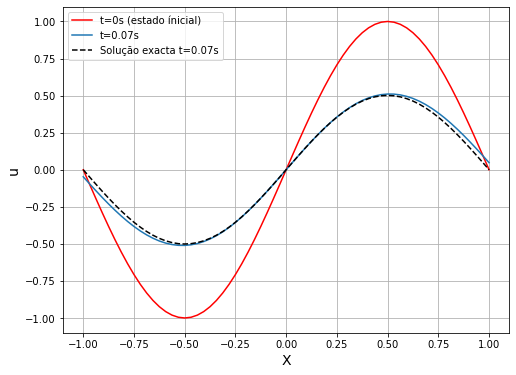

In [6]:
Tt = 0.07

x,u,init = Backward_Euler(a=1, Nx=64, xi=-1, xf=1,Tf=Tt, cond_inicial=initial, cond_fronteira=front)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label=f't={Tt}s')
plt.plot(x,exat(x,Tt),'--',color='black',label=f'Solução exacta t={Tt}s')

plt.xlabel('X',fontsize=14)
plt.ylabel('u',fontsize=14)

plt.legend()
plt.grid()
plt.show()

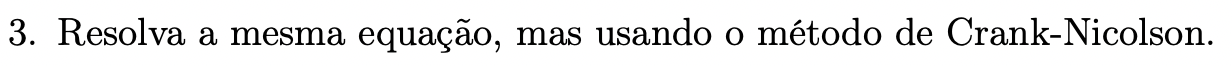

In [7]:
def CN(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
    '''
    # Calculo parametros
    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    u   = np.zeros(Nx+1)          # incógnita u no novo nível de tempo
    u_1 = np.zeros(Nx+1)          # incógnita u no nível de tempo anterior
    
    # Representação de uma matriz esparsa e do vector do lado direito
    principal  = np.zeros(Nx+1)
    inferior   = np.zeros(Nx)
    superior   = np.zeros(Nx)
    b          = np.zeros(Nx+1)
    B_p        = np.zeros(Nx+1)
    B_i        = np.zeros(Nx)
    B_s        = np.zeros(Nx)

    # Precálculo da matriz esparsa A
    principal[:] = 1 + F
    inferior[:] = -F/2  
    superior[:] = -F/2 
    
    # Inserir condições fronteira na matriz
    principal[0] = 1
    principal[Nx] = 1

    A = scipy.sparse.diags(
        diagonals=[principal, inferior, superior],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    # Precálculo da matriz esparsa B
    B_p[:] = 1 - F
    B_i[:] = F/2  
    B_s[:] = F/2 
    
    # Inserir condições fronteira na matriz
    B_p[0] = 1
    B_p[Nx] = 1

    B = scipy.sparse.diags(
        diagonals=[B_p, B_i, B_s],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    # Inserir condição inicial
    u_1 = cond_inicial(x,xf,a,F)
    init = u_1.copy()
    
    
    #evaluate right hand side at t=0
    bb = B.toarray().dot(u_1) 
    
    
    t = 0
    while t < Tf+dt: 
        
        bb[0], bb[-1] = cond_fronteira(xi,xf,t)  # condições fronteira
        
        #find solution inside domain
        u[:] = scipy.sparse.linalg.spsolve(A,bb)
        #update right hand side
        bb = B.toarray().dot(u) 
        
        #u_1 = u
        t += dt
        
    return x,u,init

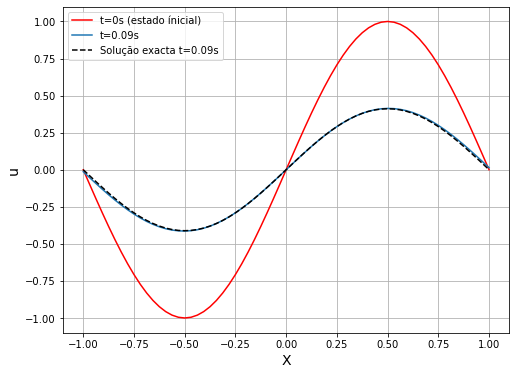

In [15]:
Tt = 0.09

x,u,init = CN(a=1, Nx=64, xi=-1, xf=1,Tf=Tt, cond_inicial=initial, cond_fronteira=front)

plt.figure(figsize=(8,6))
plt.plot(x,init,color='r',label='t=0s (estado ínicial)')
plt.plot(x,u,label=f't={Tt}s')
plt.plot(x,exat(x,Tt),'--',color='black',label=f'Solução exacta t={Tt}s')

plt.xlabel('X',fontsize=14)
plt.ylabel('u',fontsize=14)

plt.legend()
plt.grid()
plt.show()

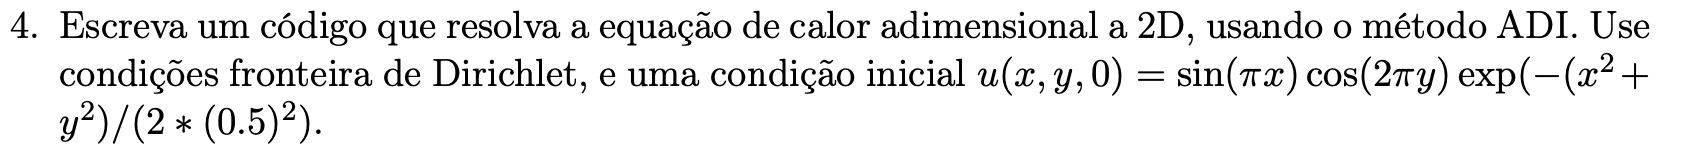

In [16]:
def ADI(a, Nx, xi, xf, Tf, cond_inicial, cond_fronteira,Ny=None,yi=None,yf=None):
    '''
    a: parâmetro de difusão, dtype=float
    xi: x inicial, dtype=float
    xf: x final, dtype=float
    Nx: número de pontos em x, dtype=int
    
    ---> domínio = [xi,xf] com Nx pontos
    
    Tf: Tempo final, dtype=int
    
    cond_inicial: 
         \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: x[i],xf,a,F
         output: float
    
    cond_fronteira:
        \\função para condição de fronteira, os argumentos devem estar no formato *args e os inputs serao
         input: xi,xf,ti 
         output: tuple, dtype=float
         
    '''
    
    # Calculo parametros
    x    = np.linspace(xi, xf, Nx+1)    # nodos da grelha no espaço
    dx   = x[1] - x[0]
    dt   = dx**2/(2*a)                # calculando dt
    F    = a*dt/dx**2 # número de Fourier da malha
    
    # Caso for uma grid quadrada definimos yy apartir de xx
    if Ny==None:
        Ny,y,dy = Nx,x,dx
    else:
        y    = np.linspace(yi, yf, Ny+1)    # nodos da grelha no espaço
        dy   = y[1] - y[0]
    
    
    # Começamos por definir alpha_x e alpha_y
    alp_x = dt/dx**2
    alp_y = dt/dy**2
    
    # Definimos a matriz A:
    # Representação de uma matriz esparsa e do vector do lado direito
    principal  = np.zeros(Nx+1)
    inferior = np.zeros(Nx)
    superior = np.zeros(Nx)
    
    # Precálculo da matriz esparsa
    principal[:] = 1 + alp_x
    inferior[:] = -alp_x  
    superior[:] = -alp_x
    

    A = scipy.sparse.diags(
        diagonals=[principal, inferior, superior],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    
    
    
    # Definimos então o vector B no instante inicial (B_0)
    
    # Inserir condição inicial
    X,Y = np.meshgrid(x,y)
    init = cond_inicial(X,Y)
    U = init.copy()
    u = np.zeros((U.shape)) # u_1/2
    
    b = np.zeros((init.shape))
    
    # Definimos a matriz C:
    # Representação de uma matriz esparsa e do vector do lado direito
    princ_y  = np.zeros(Ny+1)
    inf_y = np.zeros(Ny)
    sup_y = np.zeros(Ny)
    
    # Precálculo da matriz esparsa
    princ_y[1:-1] = 1 + 2*alp_y
    inf_y[:] = -alp_y  
    sup_y[:] = -alp_y
    
    # Inserir condições fronteira na matriz
    princ_y[0] = princ_y[-1] = 1 + alp_y

    C = scipy.sparse.diags(
        diagonals=[princ_y, inf_y, sup_y],
        offsets=[0, -1, 1], shape=(Ny+1, Ny+1),
        format='csr')
    
    # Iniciar matriz d
    d = np.zeros((init.shape))   
    
    
    t = 0
    while t < Tf+dt: 
        # Calculamos b
        b[0,:]  = (1-alp_y)*U[0,:]  + alp_y*U[1,:] # Primeira linha i=0
        b[1:-1,:] = alp_y*U[0:-2,:] + (1-2*alp_y)*U[1:-1,:] + alp_y*U[2:,:] # Linhas do 'meio' i=[1,I-2]
        b[-1,:] = alp_y*U[-2,:] + (1-alp_y)*U[-1,:] # Última linha i=I-1
        
        
        b[0,:] = b[:,0] = b[-1,:] = b[:,-1] =  0 #cond_fronteira(xi,xf,t)  # condições fronteira
        
        #find solution inside domain
        u[:] = scipy.sparse.linalg.spsolve(A,b)
        
        # Calculamos d
        d[:,0]  = (1-alp_x)*u[::-1,0]  + alp_x*u[::-1,1] # Primeira linha i=0
        d[:,1:-1] = alp_x*u[::-1,0:-2] + (1-2*alp_x)*u[::-1,1:-1] + alp_x*u[::-1,2:]
        d[:,-1] = alp_x*u[::-1,-2] + (1-alp_x)*u[::-1,-1] # Última linha i=I-1
        
        d[0,:] = d[:,0] = d[-1,:] = d[:,-1] =  0 #cond_fronteira(xi,xf,t)  # condições fronteira
        
        
        
        #find solution inside domain
        U[:] = scipy.sparse.linalg.spsolve(C,d)
        
        #u_1 = u
        t += dt
        
    return U #x,u,init

In [10]:
def INIT(x,y):
    #np.sin(np.pi*x)*np.cos(2*np.pi*y)*
    return np.exp(-(x**2+y**2)/(2*(0.5)**2))

In [17]:
Temp = 8
TESTE = ADI(a=1, Nx=64, xi=-1, xf=1,Tf=Temp, cond_inicial=INIT, cond_fronteira=front)

/var/folders/8k/t_r4nndd2ll03bmm2zsmmrpc0000gn/T/ipykernel_1264/2239578210.py:109: RuntimeWarning: invalid value encountered in multiply
  d[:,1:-1] = alp_x*u[::-1,0:-2] + (1-2*alp_x)*u[::-1,1:-1] + alp_x*u[::-1,2:]
/var/folders/8k/t_r4nndd2ll03bmm2zsmmrpc0000gn/T/ipykernel_1264/2239578210.py:98: RuntimeWarning: invalid value encountered in multiply
  b[1:-1,:] = alp_y*U[0:-2,:] + (1-2*alp_y)*U[1:-1,:] + alp_y*U[2:,:] # Linhas do 'meio' i=[1,I-2]


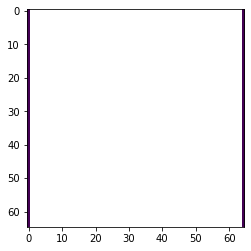

In [18]:
plt.imshow(TESTE)